Follows from [single_exposure_modeling_wcupy_modeledspec](single_exposure_modeling_wcupy_modeledspec.ipynb)

In [2]:
import os
from pathlib import Path

import numpy as np
import cupy as cp


from tqdm.notebook import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from spectres import spectres

from jwst import datamodels

import webbpsf

from IPython import display

def play_text_sound(txt):
    os.system(f'espeak -w /tmp/temp.wav "{txt}"')
    return display.Audio(filename='/tmp/temp.wav', autoplay=True)

In [ ]:
os.

In [2]:
%matplotlib inline

visualization.quantity_support()
from matplotlib import pyplot as plt

In [3]:
data_dir = Path('widened_2')

test_path = list(data_dir.glob('*04101_00001_nrs2_cal.fits'))
assert len(test_path) == 1
test_path = test_path[0]

base = test_path.stem.replace('_cal', '')
test_uncal_path = Path(f'mastDownload/JWST/{base}/{base}_uncal.fits')

test_dm = datamodels.open(test_path)

example_slit = test_dm.slits[50]

wls = np.quantile(example_slit.wavelength[np.isfinite(example_slit.wavelength)], [0, .5,1])*u.micron

## Create the PSF and check its size

See [single_exposure_modeling_wcupy_modeledspec](single_exposure_modeling_wcupy_modeledspec.ipynb) for justification of these PSF parameters

In [4]:
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=4, fov_pixels=2*3)

# Load the model spectrum and degrade

See [single_exposure_modeling_wcupy_modeledspec](single_exposure_modeling_wcupy_modeledspec.ipynb) for proof that this is a reasonable model resolution

In [5]:
phoenix_model = fits.open('lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = specutils.Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

2023-05-12 19:39:47,078 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [6]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit
phoenix_lowres_wl_cens = (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2

phoenix_lowres_flux = spectres(phoenix_lowres_wl_cens.to(wls.unit).value, 
                               phoenix_sub_spec.spectral_axis.to(wls.unit).value, 
                               phoenix_sub_spec.flux.value)*phoenix_sub_spec.flux.unit
phoenix_lowres = specutils.Spectrum1D(spectral_axis=phoenix_lowres_wl_cens,
                                      flux=phoenix_lowres_flux)

np.diff(phoenix_lowres.spectral_axis).mean(), len(phoenix_lowres_wl_cens)/example_slit.data.shape[1]

(<SpectralAxis 0.3 Angstrom>, 7.85400390625)

Above indicates gives the model spectral axis resolution, and how much better it is than the data (averaged over the whole image).  Implies the following $\Delta v$ for a single-pixel shift:

In [7]:
(constants.c * np.diff(phoenix_lowres.spectral_axis).mean() * len(phoenix_lowres_wl_cens)/example_slit.data.shape[1]/wls[1]).to(u.km/u.s)

<Quantity 50.42933674 km / s>

# Set up the example image and the image simulation kernels in the GPU

In [8]:
import cupy as cp

"""
Kernel design:
Blocks = (nim, yim, xim/tpb)
Threads = fast axis of image
"""

convolve_fluxline_src = r"""
extern "C" __global__
void convolve_fluxline(float* fluxim, 
                       const float* fluxpoints, const float* xcens, const float* ycens,
                       const float* psf, const float* pxls, const float* pxus, const float* pyls, const float* pyus,
                       const float psfmaxdistsq, const int nspec, const int psfsize, const float psfpxsz) {
    float fluxaccum = 0;

    float gycen = blockIdx.y;
    float gyl = blockIdx.y - 0.5f;
    float gyu = blockIdx.y + 0.5f;
    
    float gxcen = blockIdx.z * blockDim.x + threadIdx.x;
    float gxl = gxcen - 0.5f;
    float gxu = gxcen + 0.5f;

    for (int i = 0; i < nspec; i++) {
        float xc = xcens[i];
        float yc = ycens[i];

        float dx = xc - gxcen;
        float dy = yc - gycen;
        if ((dx*dx + dy*dy) < psfmaxdistsq) {
            for (int j=0; j < psfsize; j++) {
                // pxls need to be in *image* pixels, not psf pixels
                float pxl = pxls[j] + xc;
                float pxu = pxl + psfpxsz;
                float pyl = pyls[j] + yc;
                float pyu = pyl + psfpxsz;
                dx = fminf(pxu, gxu) - fmaxf(pxl, gxl);
                if (dx > 0) {
                    dy = fminf(pyu, gyu) - fmaxf(pyl, gyl);
                    if (dy > 0) {
                        fluxaccum += fluxpoints[i]*psf[j]*dx*dy;
                    }
                }
            }
        }
    }

    int subdim = blockDim.x*gridDim.z;
    int fluxidx = threadIdx.x + blockIdx.z*blockDim.x + blockIdx.y*subdim + blockIdx.x*subdim*gridDim.y;
    fluxim[fluxidx] = fluxaccum;

}
"""[1:-1]
convolve_fluxline = cp.RawKernel(convolve_fluxline_src, 'convolve_fluxline')

def do_convolve_fluxline(imdata, wcs, simdata, modelspec, psfhdu, raoff=None, decoff=None, v=0*u.km/u.s, tpb=1024):
    if simdata is None: 
        simdata = np.empty_like(imdata)
        
    c_imdata = cp.array(imdata, copy=False, dtype=cp.float32, ndmin=3)
    c_simdata = cp.array(simdata, copy=False, dtype=cp.float32, ndmin=3)
    
    ra = example_slit.source_ra << u.deg
    if raoff is not None:
        ra = ra + raoff
    dec = example_slit.source_dec << u.deg
    if decoff is not None:
        dec = dec + decoff
    
    zp1 = v/constants.c + 1
    x_model, y_model = wcs.world_to_pixel(SkyCoord(ra, dec), modelspec.spectral_axis * zp1)
    c_x_model = cp.asarray(x_model, dtype=cp.float32)
    c_y_model = cp.asarray(y_model, dtype=cp.float32)
    c_modelspec_flux = cp.asarray(modelspec.flux.value, dtype=cp.float32)
    
    
    c_psf = cp.asarray(psfhdu.data, dtype=cp.float32)
    psf_oversampling = psfhdu.header['DET_SAMP']
    xg, yg = np.mgrid[-psfhdu.shape[0]/2:psfhdu.shape[0]/2:psfhdu.shape[0]*1j,
                      -psfhdu.shape[1]/2:psfhdu.shape[1]/2:psfhdu.shape[1]*1j]
    c_pxls = cp.asarray((xg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pxus = cp.asarray((xg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyls = cp.asarray((yg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyus = cp.asarray((yg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_psfmaxdistsq = cp.float32((np.max([xg, yg])/psf_oversampling/2)**2)

    c_nspec = cp.int64(c_modelspec_flux.size)
    c_psfsize = cp.int64(c_psf.size)
    c_psfpxsize = cp.float32(0.5/psf_oversampling)
    
    convolve_fluxline((c_simdata.shape[0], c_simdata.shape[1], c_simdata.shape[2]/tpb), (tpb,), 
                      (c_simdata, c_modelspec_flux, c_x_model, c_y_model,
                       c_psf, c_pxls, c_pxus, c_pyls, c_pyus, c_psfmaxdistsq,
                       c_nspec, c_psfsize, c_psfpxsize))
    
    return c_simdata

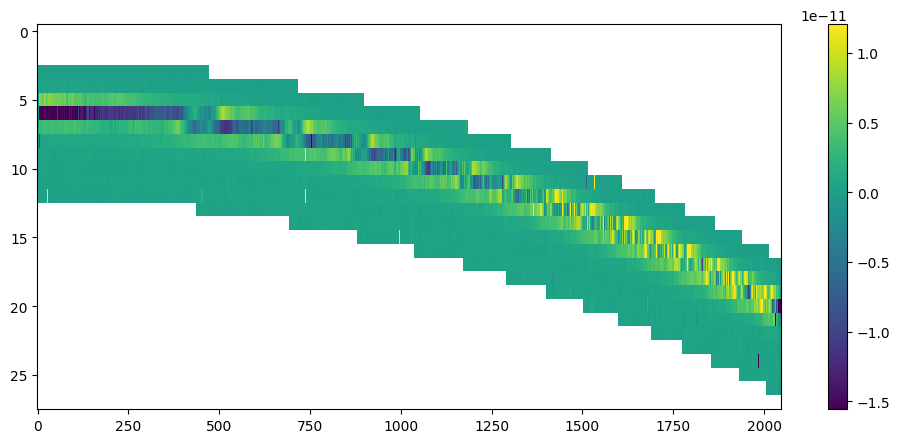

In [10]:
o = .5*u.arcsec
model = do_convolve_fluxline(example_slit.data, example_slit.meta.wcs, None, phoenix_lowres, psf['OVERDIST'], 
                             raoff=o, decoff=-o)

nans = np.isnan(example_slit.data)
model_quan = cp.quantile(model[0, ~nans], .99).get()
data_quan = np.quantile(example_slit.data[~nans], .99)
model_to_data_scale = data_quan/model_quan

datmmod = example_slit.data - model.get()[0]*model_to_data_scale

plt.figure(figsize=(12, 5))
visualization.imshow_norm(datmmod, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest')
plt.colorbar();

And what do the histograms look like?

/tmp/ipykernel_133/4013836379.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(np.abs(example_slit.data.ravel())), range=rng, bins='auto', histtype='step');
/tmp/ipykernel_133/4013836379.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(np.abs((model.get()[0]*model_to_data_scale).ravel())), range=rng, bins='auto', histtype='step');
/tmp/ipykernel_133/4013836379.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(np.abs(datmmod.ravel())), range=rng, bins='auto', histtype='step');


array([-1.9052889e-02, -1.5536455e-09, -9.2839586e-16, -9.2428722e-16,
       -8.6200484e-16, -5.8172142e-16, -4.7329644e-16, -4.0790891e-16,
       -2.0847924e-16,  2.5607419e-17,  4.5239553e-16,  6.6333082e-16,
        1.0704667e-10,  1.1213485e-10,  1.1900789e-10,  1.2091902e-10,
        2.1404453e-10,  2.2237467e-10,  2.9077482e-10,  2.9325931e-10,
        3.3358677e-10,  2.3639006e-04,  3.5736363e-03,  1.0373003e-02],
      dtype=float32)

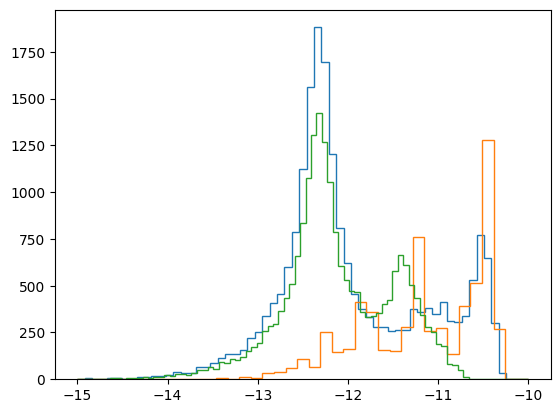

In [11]:
rng = (-15, -10)
plt.hist(np.log10(np.abs(example_slit.data.ravel())), range=rng, bins='auto', histtype='step');
plt.hist(np.log10(np.abs((model.get()[0]*model_to_data_scale).ravel())), range=rng, bins='auto', histtype='step');
plt.hist(np.log10(np.abs(datmmod.ravel())), range=rng, bins='auto', histtype='step');
#plt.semilogy()

# this checks for outlier pixels beyond the histogram
offedge_msk = (~np.isnan(example_slit.data)&(example_slit.data!=0) &
                ((np.abs(example_slit.data)<10**rng[0])|(np.abs(example_slit.data)>10**rng[1])))
sorti = np.argsort(example_slit.data[offedge_msk])
example_slit.data[offedge_msk][sorti]

What's up with the glitch pixels?  To look at those probably should look at the ramp files, which we didn't download. See [uncal_ramp_experiments](uncal_ramp_experiments.ipynb) for more on that.  In the meantime, what about the dq array?

In [12]:
example_slit.dq[offedge_msk][sorti]

array([   2622465, 1093190661,          0,          4,          0,
                4,          0,          0,          0,          4,
                0,          0,          6,          2,          4,
                4,      32775,          0,          2,          6,
                4, 1092617217, 1080558593,    2622465], dtype=uint32)

Aha many are flagged as bad.  Wlets get a sense of the DQ pixel patterns. For interpretation of DQ see https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags:

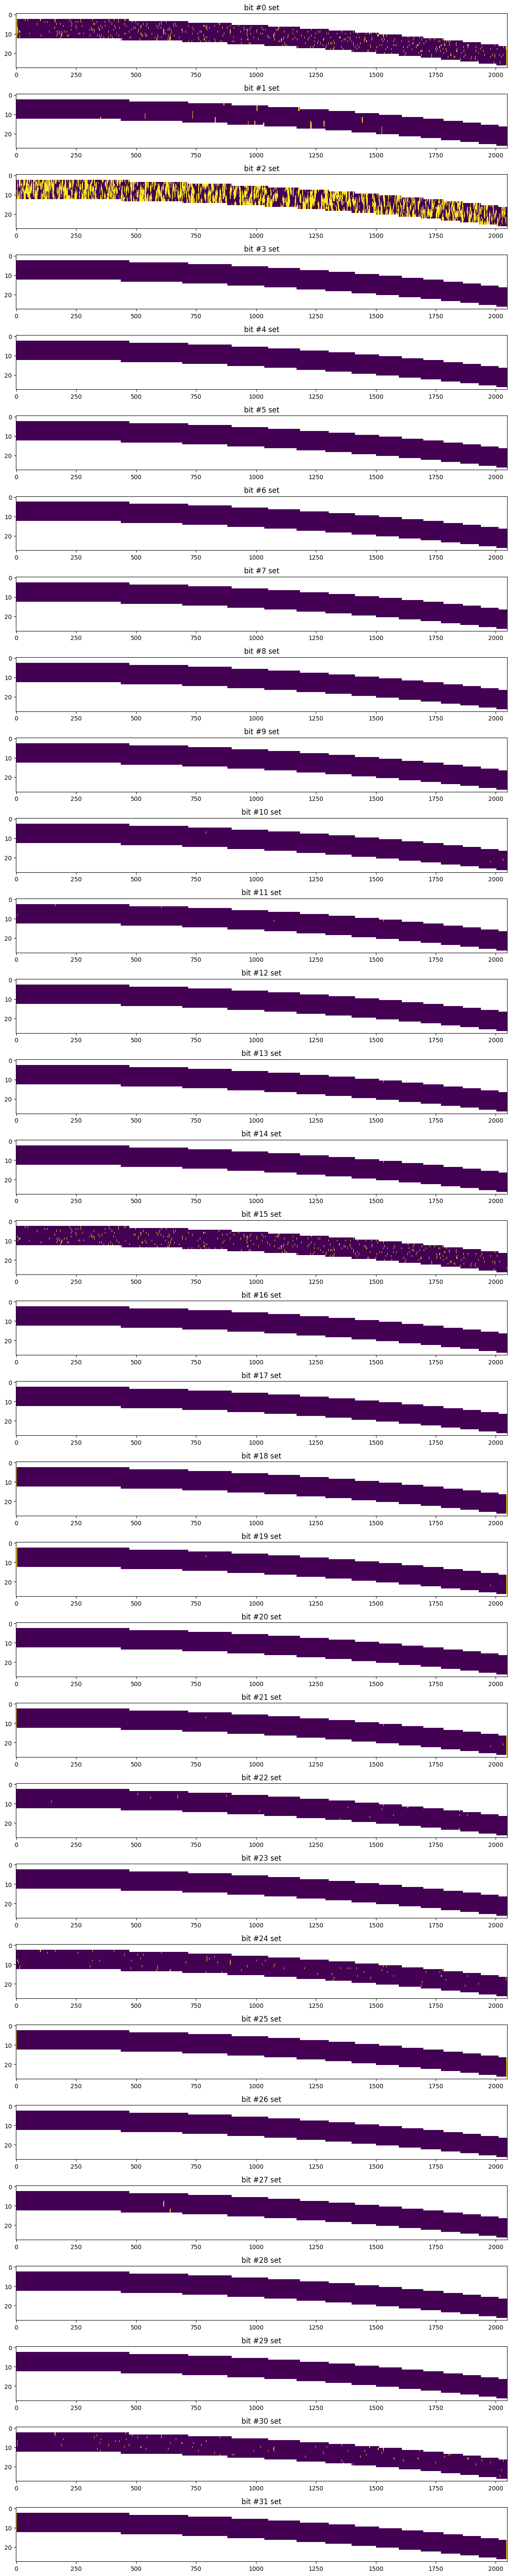

In [13]:
fig, axs = plt.subplots(32,1, figsize=(12, 60))
for i, ax in enumerate(axs.ravel()):
    dqim = (example_slit.dq & (1 << i)).astype(float)
    dqim[np.isnan(example_slit.data)] = np.nan
    ax.imshow(dqim, aspect='auto', interpolation='nearest')
    ax.set_title(f'bit #{i} set')
fig.tight_layout()

Clearly something is wonky with bit 2 ("Jump detected during exposure", and maybe also 15 ("Telegraph pixel"), so don't flag those, but set the others to NaN and see what we get:

(<matplotlib.image.AxesImage at 0x7ff066ad79d0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7ff066ad6110>)

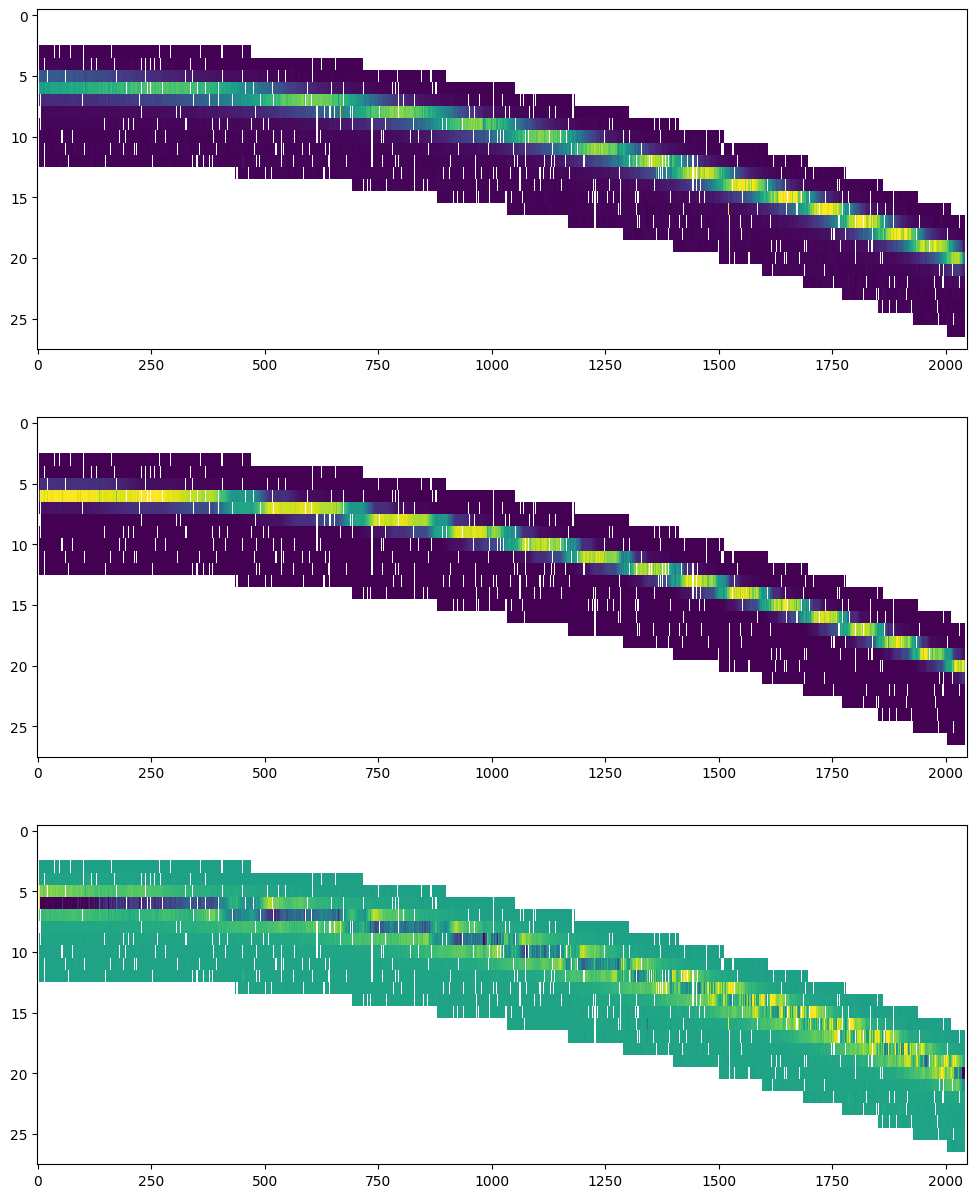

In [14]:
datfilt = example_slit.data.copy()
modfilt = model.get()[0].copy()
datmmodfilt = datmmod.copy()

all32 = (1 << 32) - 1
bits_to_call_bad = all32 & ~(1 << 2) & ~(1 << 15)
bad_msk = (example_slit.dq & bits_to_call_bad) > 0

datfilt[bad_msk] = np.nan
modfilt[bad_msk] = np.nan
datmmodfilt[bad_msk] = np.nan

fig, axs = plt.subplots(3, 1, figsize=(12, 15))
visualization.imshow_norm(datfilt, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=axs.ravel()[0])
visualization.imshow_norm(modfilt, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=axs.ravel()[1])
visualization.imshow_norm(datmmodfilt, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=axs.ravel()[2])

Looks like filtering on these dq values catches all the obvious outliers.

# MCMC inference

In [364]:
import emcee
import corner

In [409]:
GAUSS_LPRETERM = -0.5*np.log(2*np.pi)
def loglikes(ps, data, std, wcs):
    vkms, raoff, decoff, A = ps
    sim_data = do_convolve_fluxline(data, wcs, None, phoenix_lowres, psf['OVERDIST'], 
                                    v=vkms*u.km/u.s, raoff=raoff*u.arcsec, decoff=decoff*u.arcsec).get()[0]
    
    x = (sim_data*A-data)/std
    return -0.5*x**2 - np.log(std) + GAUSS_LPRETERM
    return np.nansum(loglikes)

def logpri(ps, Abnds):
    # starndard uniform priors
    vkms, raoff, decoff, A = ps
    if np.hypot(raoff, decoff) > 0.3:
        return np.NINF
    if vkms < -1000 or vkms > 1000:
        return np.NINF
    if A < Abnds[0] or A > Abnds[1]:
        return np.NINF
    
    return 0

def logprob(ps, data, std, wcs, Abnds):
    logprival = logpri(ps, Abnds)
    if logprival == np.NINF:
        return np.NINF
    return np.nansum(loglikes(ps, data, std, wcs)) + logprival 

In [410]:
Abnds = (.1*model_to_data_scale, model_to_data_scale*3)

sampler = emcee.EnsembleSampler(12, 4, logprob, 
                                args=(datfilt, example_slit.err, example_slit.meta.wcs, Abnds))
p0s = np.random.rand(12, 4) - .5 # [-.5, 5]

# intentionally only filling half the prior
p0s[:, 1:3] *= .3
p0s[:, 0] *= 1000  

p0s[:, 3] += .5
p0s[:, 3] *= (Abnds[1]-Abnds[0])/2
p0s[:, 3] += Abnds[0]

In [411]:
res = sampler.run_mcmc(p0s, 1000, progress='notebook')
np.save('test_chain', sampler.chain)

play_text_sound('Alldone!')

/tmp/ipykernel_163/3562824338.py:8: RuntimeWarning: divide by zero encountered in log
  return -0.5*x**2 - np.log(std) + GAUSS_LPRETERM


  0%|          | 0/1000 [00:00<?, ?it/s]

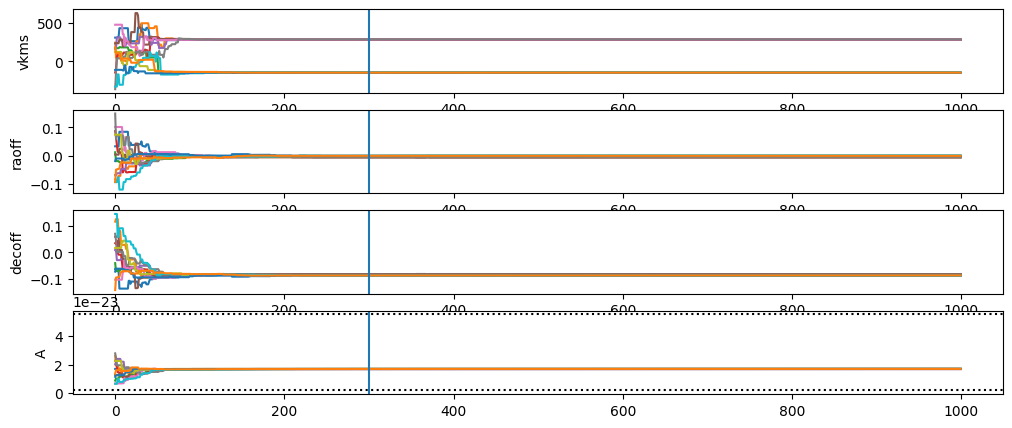

<Figure size 800x800 with 0 Axes>

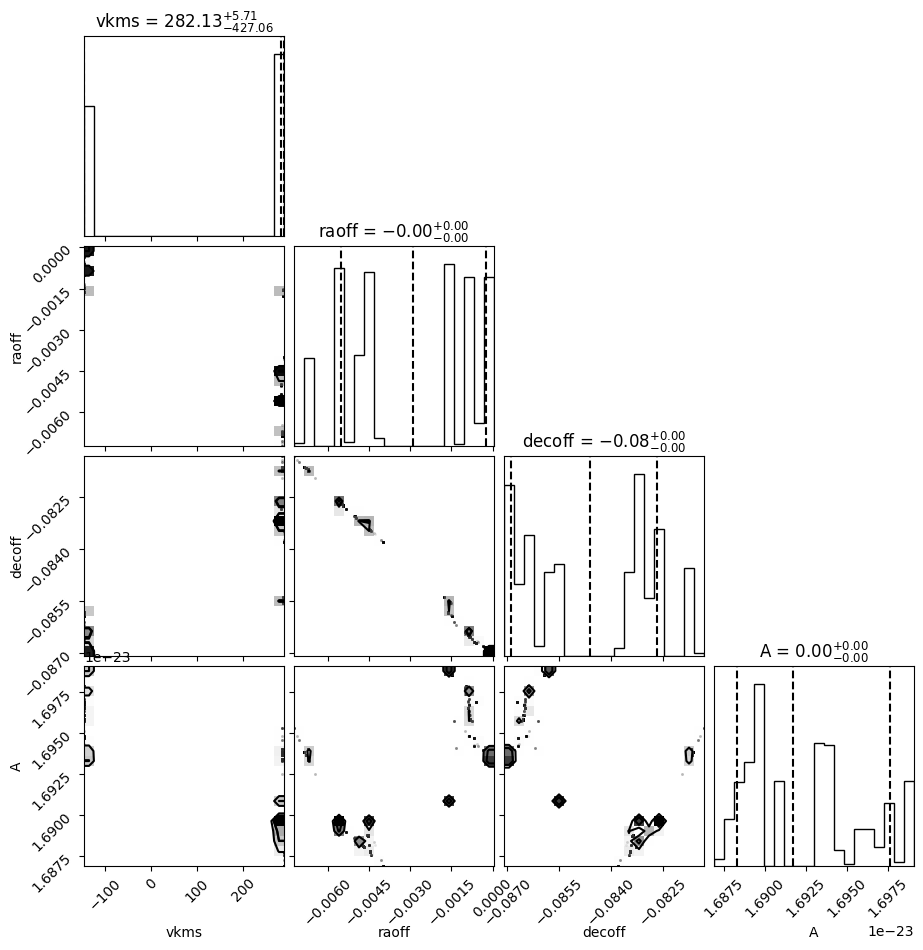

In [413]:
labels = 'vkms, raoff, decoff, A'.split(', ')
ndiscard = 300

fig, axs = plt.subplots(len(labels), 1, figsize=(12, 5))
for i, (l, ax) in enumerate(zip(labels, axs)):
    ax.plot(sampler.chain.T[i])
    ax.set_ylabel(l)
    ax.axvline(ndiscard)
    if l=='A':
        for b in Abnds:
            ax.axhline(b, c='k', ls=':')

plt.figure(figsize=(8, 8))
corner.corner(sampler.get_chain(discard=ndiscard, flat=True), labels=labels, show_titles=True, quantiles=[.1,.5,.9]);

Two modes!  Lets compare them:

In [452]:
tchains = np.tile(np.arange(sampler.chain.shape[1]), sampler.chain.shape[0]).reshape(sampler.chain.shape[0], sampler.chain.shape[1])
assert sampler.chain.shape[:-1] == tchains.shape

In [463]:
mode1 = sampler.chain[...,0] < 0
mode2 = sampler.chain[...,0] > 0
chain1 = sampler.chain[mode1]
tc1 = tchains[mode1]
chain2 = sampler.chain[mode2]
tc2 = tchains[mode2]

2023-04-11 02:12:59,438 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:12:59,459 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:12:59,473 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:12:59,492 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:12:59,505 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:12:59,516 - stpipe - WARNING - Too few points to create valid contours


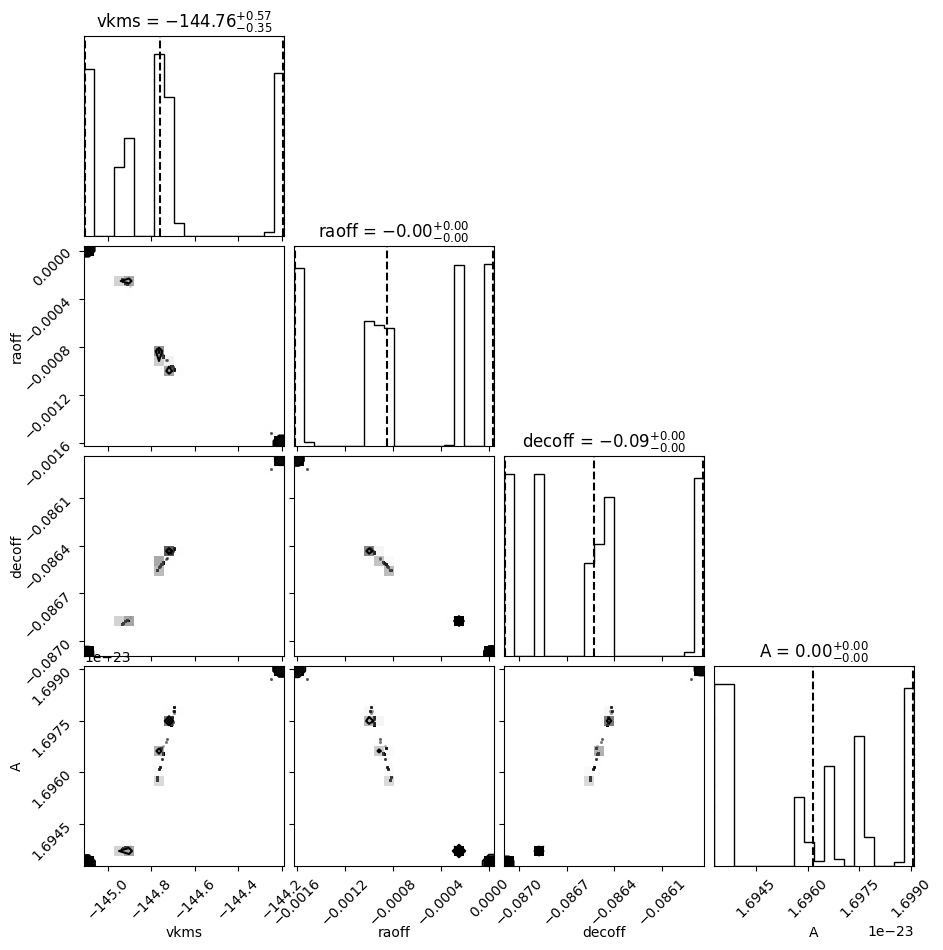

In [478]:
corner.corner(chain1[tc1>500], labels=labels, show_titles=True, quantiles=[.1,.5,.9]);

2023-04-11 02:13:22,899 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:13:22,918 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:13:22,932 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:13:22,953 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:13:22,964 - stpipe - WARNING - Too few points to create valid contours
2023-04-11 02:13:22,975 - stpipe - WARNING - Too few points to create valid contours


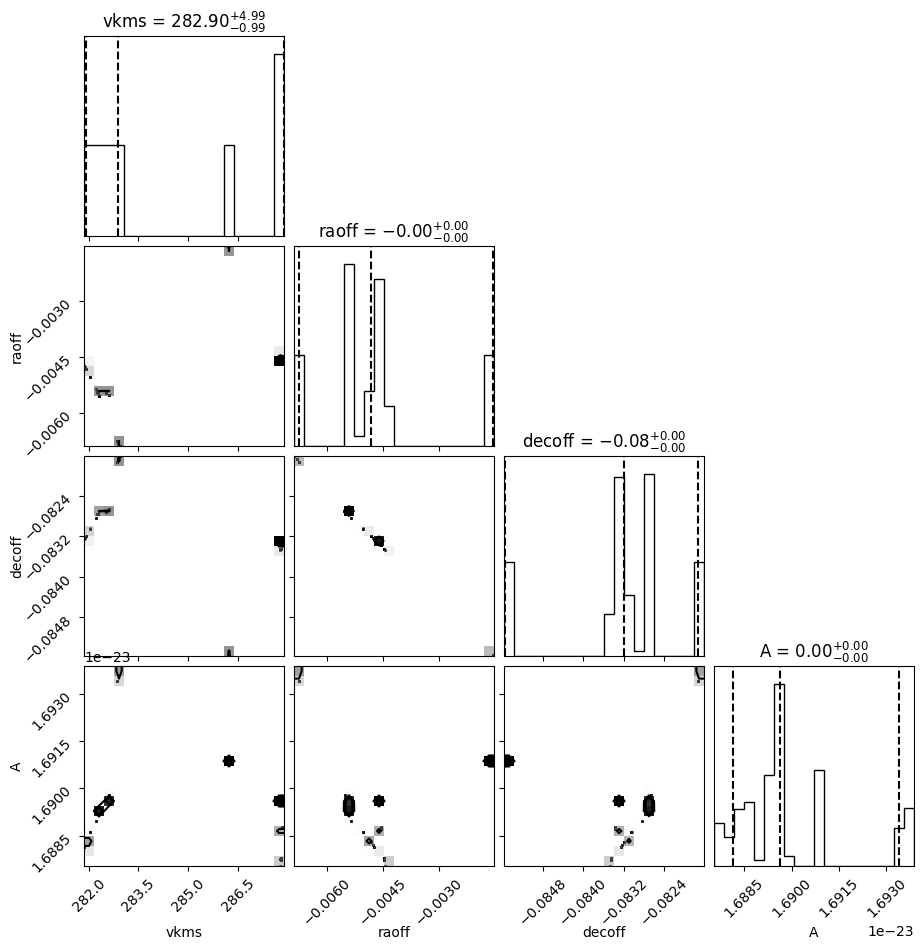

In [479]:
corner.corner(chain2[tc2>500], labels=labels, show_titles=True, quantiles=[.1,.5,.9]);

Hmm, so what do these ra/dec offsets mean in terms of pixels?  Lets get the scale:

Text(0.5, 0, 'arcsec/pixel')

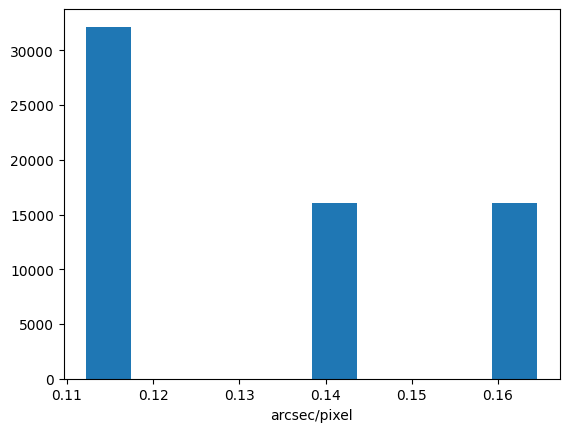

In [500]:
source_coo = SkyCoord(example_slit.source_ra, example_slit.source_dec, unit=u.deg)
x0, y0 = example_slit.meta.wcs.world_to_pixel(source_coo, phoenix_lowres.spectral_axis)

c1, _ = example_slit.meta.wcs.pixel_to_world(x0+1, y0)
c2, _ = example_slit.meta.wcs.pixel_to_world(x0, y0+1)
c3, _ = example_slit.meta.wcs.pixel_to_world(x0-1, y0)
c4, _ = example_slit.meta.wcs.pixel_to_world(x0, y0-1)

dcs = np.concatenate([c1.separation(source_coo).arcsec,
                      c2.separation(source_coo).arcsec,
                      c3.separation(source_coo).arcsec,
                      c4.separation(source_coo).arcsec])
dcs = dcs[~np.isnan(dcs)]
plt.hist(dcs)
plt.xlabel('arcsec/pixel')

So the offsets above are ~1/10 of a pixel

## Now try comparing to the reduced version?